# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

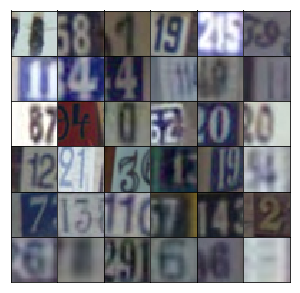

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [7]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x, alpha * x)
        
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x, alpha * x)
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x, alpha * x)

        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x, output_dim, 4, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [11]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(x, 64, 4, strides=2, padding='same')
        x = tf.maximum(x, alpha * x)
        # 16*16*128
        
        x = tf.layers.conv2d(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, alpha * x)
        # 8*8*128
        
        x = tf.layers.conv2d(x, 256, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, alpha * x)
        # 4*4*256
        
        x = tf.reshape(x, (-1, 4*4*256))
        
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [14]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [15]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [16]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [17]:
real_size = (32,32,3)
z_size = 128
learning_rate = 0.0002
batch_size = 512
epochs = 20
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/20... Discriminator Loss: 2.6320... Generator Loss: 0.2382
Epoch 1/20... Discriminator Loss: 1.0028... Generator Loss: 0.9881
Epoch 1/20... Discriminator Loss: 0.6830... Generator Loss: 1.1969
Epoch 1/20... Discriminator Loss: 0.5002... Generator Loss: 1.6125
Epoch 1/20... Discriminator Loss: 0.2673... Generator Loss: 2.2026
Epoch 1/20... Discriminator Loss: 0.4374... Generator Loss: 1.6566
Epoch 1/20... Discriminator Loss: 0.7531... Generator Loss: 1.3753
Epoch 1/20... Discriminator Loss: 0.9497... Generator Loss: 1.2474
Epoch 1/20... Discriminator Loss: 0.8897... Generator Loss: 1.4530
Epoch 1/20... Discriminator Loss: 0.8935... Generator Loss: 1.0811


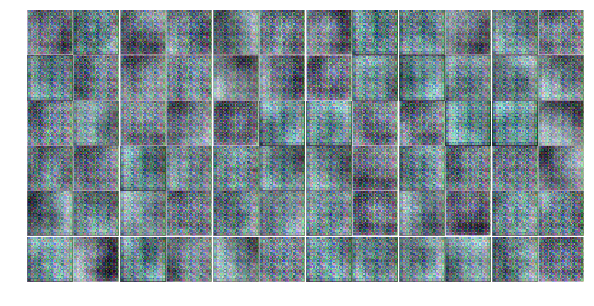

Epoch 1/20... Discriminator Loss: 0.8464... Generator Loss: 1.2745
Epoch 1/20... Discriminator Loss: 0.9080... Generator Loss: 1.3524
Epoch 1/20... Discriminator Loss: 1.0653... Generator Loss: 0.7878
Epoch 1/20... Discriminator Loss: 0.7131... Generator Loss: 1.3999
Epoch 2/20... Discriminator Loss: 0.6609... Generator Loss: 1.6127
Epoch 2/20... Discriminator Loss: 0.7371... Generator Loss: 1.6763
Epoch 2/20... Discriminator Loss: 0.7700... Generator Loss: 1.1508
Epoch 2/20... Discriminator Loss: 0.7750... Generator Loss: 1.2073
Epoch 2/20... Discriminator Loss: 0.7973... Generator Loss: 1.4595
Epoch 2/20... Discriminator Loss: 0.6488... Generator Loss: 1.3369


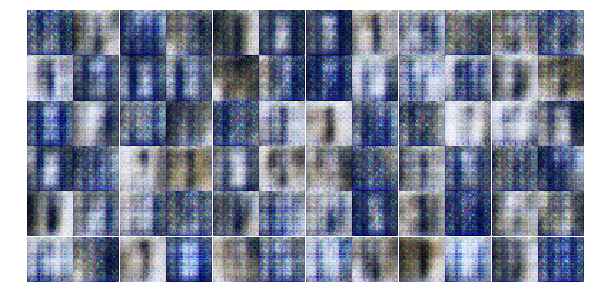

Epoch 2/20... Discriminator Loss: 0.7056... Generator Loss: 1.7296
Epoch 2/20... Discriminator Loss: 0.5727... Generator Loss: 1.3243
Epoch 2/20... Discriminator Loss: 0.5762... Generator Loss: 1.1717
Epoch 2/20... Discriminator Loss: 1.2646... Generator Loss: 0.5589
Epoch 2/20... Discriminator Loss: 0.7167... Generator Loss: 1.4504
Epoch 2/20... Discriminator Loss: 0.4076... Generator Loss: 1.8468
Epoch 2/20... Discriminator Loss: 0.5239... Generator Loss: 2.0533
Epoch 2/20... Discriminator Loss: 0.5679... Generator Loss: 3.2013
Epoch 3/20... Discriminator Loss: 0.4246... Generator Loss: 2.1226
Epoch 3/20... Discriminator Loss: 0.6282... Generator Loss: 1.9221


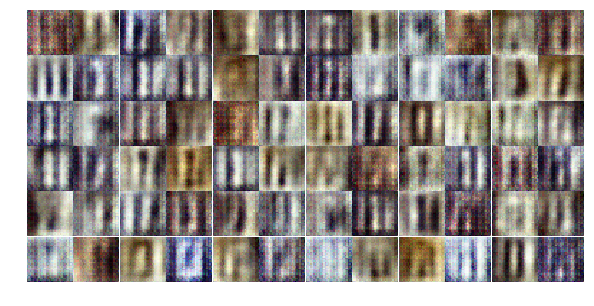

Epoch 3/20... Discriminator Loss: 0.9717... Generator Loss: 0.8575
Epoch 3/20... Discriminator Loss: 0.7234... Generator Loss: 2.1203
Epoch 3/20... Discriminator Loss: 0.4152... Generator Loss: 2.1493
Epoch 3/20... Discriminator Loss: 1.1007... Generator Loss: 2.7437
Epoch 3/20... Discriminator Loss: 0.8098... Generator Loss: 1.1319
Epoch 3/20... Discriminator Loss: 0.7920... Generator Loss: 1.5164
Epoch 3/20... Discriminator Loss: 0.5465... Generator Loss: 1.7008
Epoch 3/20... Discriminator Loss: 0.4059... Generator Loss: 1.5866
Epoch 3/20... Discriminator Loss: 0.7615... Generator Loss: 0.9343
Epoch 3/20... Discriminator Loss: 1.6510... Generator Loss: 2.5893


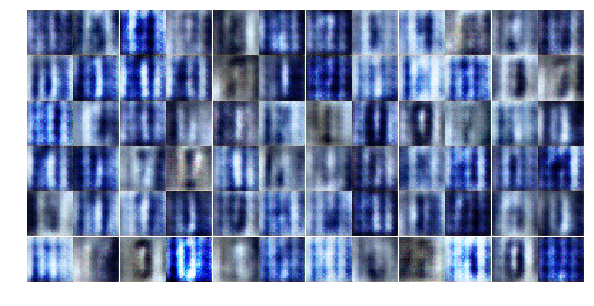

Epoch 3/20... Discriminator Loss: 0.3238... Generator Loss: 2.0378
Epoch 3/20... Discriminator Loss: 0.5040... Generator Loss: 1.9790
Epoch 3/20... Discriminator Loss: 0.5430... Generator Loss: 2.2490
Epoch 4/20... Discriminator Loss: 0.5071... Generator Loss: 2.0497
Epoch 4/20... Discriminator Loss: 0.4545... Generator Loss: 1.7255
Epoch 4/20... Discriminator Loss: 0.4109... Generator Loss: 2.5072
Epoch 4/20... Discriminator Loss: 0.3473... Generator Loss: 3.0081
Epoch 4/20... Discriminator Loss: 0.4072... Generator Loss: 1.6327
Epoch 4/20... Discriminator Loss: 0.4125... Generator Loss: 1.9736
Epoch 4/20... Discriminator Loss: 0.7278... Generator Loss: 2.6215


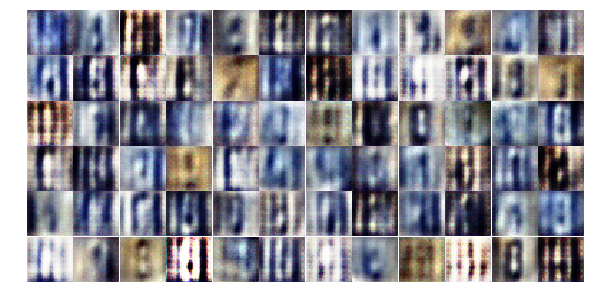

Epoch 4/20... Discriminator Loss: 0.9031... Generator Loss: 2.6344
Epoch 4/20... Discriminator Loss: 0.6052... Generator Loss: 2.2216
Epoch 4/20... Discriminator Loss: 0.7839... Generator Loss: 1.0697
Epoch 4/20... Discriminator Loss: 0.4968... Generator Loss: 1.6842
Epoch 4/20... Discriminator Loss: 0.8685... Generator Loss: 0.9157
Epoch 4/20... Discriminator Loss: 0.6493... Generator Loss: 1.4786
Epoch 4/20... Discriminator Loss: 1.1567... Generator Loss: 1.2232
Epoch 5/20... Discriminator Loss: 0.9955... Generator Loss: 2.3838
Epoch 5/20... Discriminator Loss: 1.1746... Generator Loss: 2.1079
Epoch 5/20... Discriminator Loss: 1.0532... Generator Loss: 1.6580


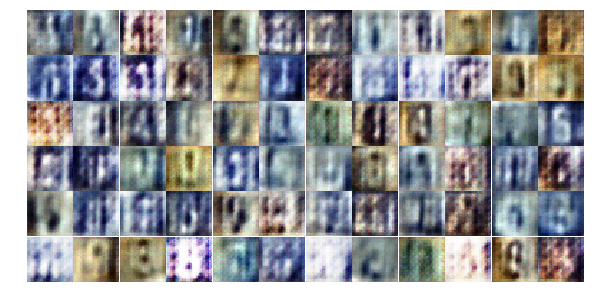

Epoch 5/20... Discriminator Loss: 0.7440... Generator Loss: 1.3512
Epoch 5/20... Discriminator Loss: 0.8126... Generator Loss: 1.7644
Epoch 5/20... Discriminator Loss: 0.7018... Generator Loss: 1.7584
Epoch 5/20... Discriminator Loss: 1.1080... Generator Loss: 0.6677
Epoch 5/20... Discriminator Loss: 1.0604... Generator Loss: 0.7571
Epoch 5/20... Discriminator Loss: 0.5971... Generator Loss: 1.9239
Epoch 5/20... Discriminator Loss: 1.0781... Generator Loss: 0.8216
Epoch 5/20... Discriminator Loss: 1.0620... Generator Loss: 0.6470
Epoch 5/20... Discriminator Loss: 0.5462... Generator Loss: 1.8062
Epoch 5/20... Discriminator Loss: 0.9346... Generator Loss: 0.6999


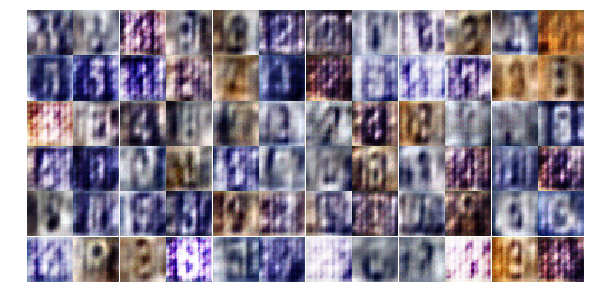

Epoch 5/20... Discriminator Loss: 1.1050... Generator Loss: 0.5895
Epoch 5/20... Discriminator Loss: 0.8986... Generator Loss: 0.6683
Epoch 6/20... Discriminator Loss: 0.5308... Generator Loss: 2.4135
Epoch 6/20... Discriminator Loss: 0.9858... Generator Loss: 0.6694
Epoch 6/20... Discriminator Loss: 1.0653... Generator Loss: 0.5660
Epoch 6/20... Discriminator Loss: 0.8378... Generator Loss: 0.7356
Epoch 6/20... Discriminator Loss: 0.2227... Generator Loss: 2.3579
Epoch 6/20... Discriminator Loss: 0.4599... Generator Loss: 4.0428
Epoch 6/20... Discriminator Loss: 0.4415... Generator Loss: 2.0004
Epoch 6/20... Discriminator Loss: 0.7727... Generator Loss: 0.8508


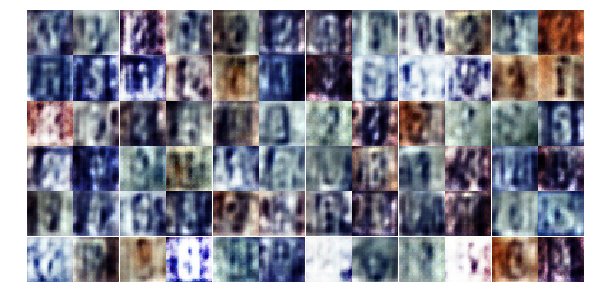

Epoch 6/20... Discriminator Loss: 0.5737... Generator Loss: 1.1458
Epoch 6/20... Discriminator Loss: 0.2635... Generator Loss: 2.0374
Epoch 6/20... Discriminator Loss: 0.3355... Generator Loss: 1.7609
Epoch 6/20... Discriminator Loss: 0.4496... Generator Loss: 2.6886
Epoch 6/20... Discriminator Loss: 0.3221... Generator Loss: 4.7184
Epoch 6/20... Discriminator Loss: 0.2617... Generator Loss: 3.0897
Epoch 7/20... Discriminator Loss: 0.6380... Generator Loss: 1.5899
Epoch 7/20... Discriminator Loss: 0.1488... Generator Loss: 5.3069
Epoch 7/20... Discriminator Loss: 0.2228... Generator Loss: 2.9373
Epoch 7/20... Discriminator Loss: 0.1776... Generator Loss: 3.4557


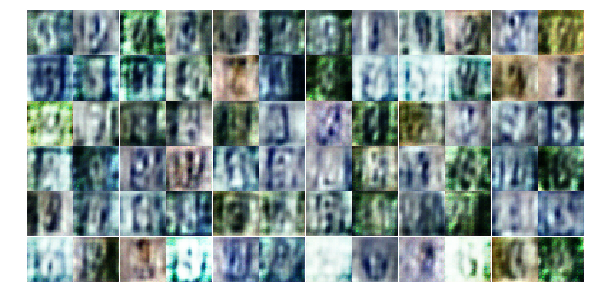

Epoch 7/20... Discriminator Loss: 0.0777... Generator Loss: 4.1157
Epoch 7/20... Discriminator Loss: 0.3567... Generator Loss: 4.6144
Epoch 7/20... Discriminator Loss: 0.8032... Generator Loss: 6.4479
Epoch 7/20... Discriminator Loss: 0.4642... Generator Loss: 2.8948
Epoch 7/20... Discriminator Loss: 0.2226... Generator Loss: 2.0840
Epoch 7/20... Discriminator Loss: 1.1178... Generator Loss: 0.5121
Epoch 7/20... Discriminator Loss: 2.1706... Generator Loss: 2.4922
Epoch 7/20... Discriminator Loss: 0.3912... Generator Loss: 1.7078
Epoch 7/20... Discriminator Loss: 0.4135... Generator Loss: 1.6343
Epoch 7/20... Discriminator Loss: 0.3062... Generator Loss: 2.9714


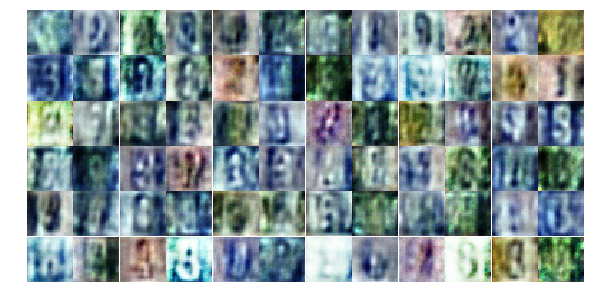

Epoch 8/20... Discriminator Loss: 1.1068... Generator Loss: 0.7033
Epoch 8/20... Discriminator Loss: 0.4970... Generator Loss: 1.2123
Epoch 8/20... Discriminator Loss: 0.9008... Generator Loss: 0.6698
Epoch 8/20... Discriminator Loss: 0.5420... Generator Loss: 3.7096
Epoch 8/20... Discriminator Loss: 0.2268... Generator Loss: 2.8227
Epoch 8/20... Discriminator Loss: 0.8493... Generator Loss: 5.7855
Epoch 8/20... Discriminator Loss: 0.2269... Generator Loss: 7.3314
Epoch 8/20... Discriminator Loss: 0.2974... Generator Loss: 2.1272
Epoch 8/20... Discriminator Loss: 0.3693... Generator Loss: 4.6202
Epoch 8/20... Discriminator Loss: 0.4226... Generator Loss: 1.7230


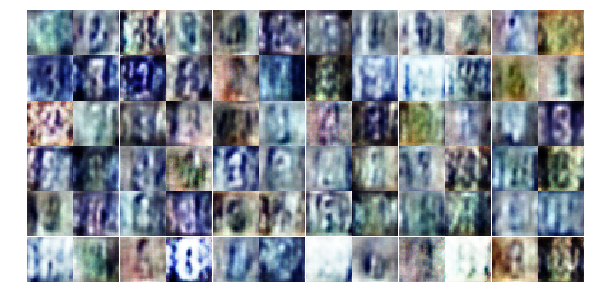

Epoch 8/20... Discriminator Loss: 0.4369... Generator Loss: 1.8435
Epoch 8/20... Discriminator Loss: 0.2527... Generator Loss: 2.3644
Epoch 8/20... Discriminator Loss: 0.7147... Generator Loss: 0.8848
Epoch 8/20... Discriminator Loss: 0.5066... Generator Loss: 1.3491
Epoch 8/20... Discriminator Loss: 0.2999... Generator Loss: 1.9354
Epoch 9/20... Discriminator Loss: 0.1575... Generator Loss: 3.0481
Epoch 9/20... Discriminator Loss: 0.5900... Generator Loss: 1.1133
Epoch 9/20... Discriminator Loss: 0.6189... Generator Loss: 3.7818
Epoch 9/20... Discriminator Loss: 0.2639... Generator Loss: 2.2666
Epoch 9/20... Discriminator Loss: 0.7207... Generator Loss: 1.3050


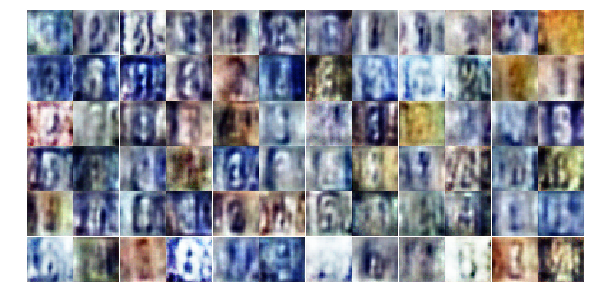

Epoch 9/20... Discriminator Loss: 0.6747... Generator Loss: 1.9759
Epoch 9/20... Discriminator Loss: 0.2708... Generator Loss: 4.3899
Epoch 9/20... Discriminator Loss: 1.1842... Generator Loss: 4.8943
Epoch 9/20... Discriminator Loss: 0.8115... Generator Loss: 0.8379
Epoch 9/20... Discriminator Loss: 0.2867... Generator Loss: 2.2130
Epoch 9/20... Discriminator Loss: 0.2910... Generator Loss: 2.2122
Epoch 9/20... Discriminator Loss: 0.2492... Generator Loss: 2.3013
Epoch 9/20... Discriminator Loss: 0.2379... Generator Loss: 2.5569
Epoch 9/20... Discriminator Loss: 0.3464... Generator Loss: 1.8654
Epoch 10/20... Discriminator Loss: 0.2925... Generator Loss: 3.3255


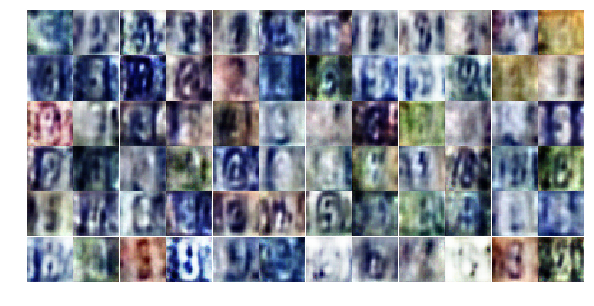

Epoch 10/20... Discriminator Loss: 1.2621... Generator Loss: 0.4229
Epoch 10/20... Discriminator Loss: 0.1693... Generator Loss: 3.3912
Epoch 10/20... Discriminator Loss: 0.2264... Generator Loss: 3.5172
Epoch 10/20... Discriminator Loss: 0.4097... Generator Loss: 1.4265
Epoch 10/20... Discriminator Loss: 0.3116... Generator Loss: 1.7455
Epoch 10/20... Discriminator Loss: 0.1618... Generator Loss: 2.5406
Epoch 10/20... Discriminator Loss: 0.7740... Generator Loss: 0.8364
Epoch 10/20... Discriminator Loss: 0.4055... Generator Loss: 1.7896
Epoch 10/20... Discriminator Loss: 0.4551... Generator Loss: 1.4900
Epoch 10/20... Discriminator Loss: 0.6388... Generator Loss: 0.9691


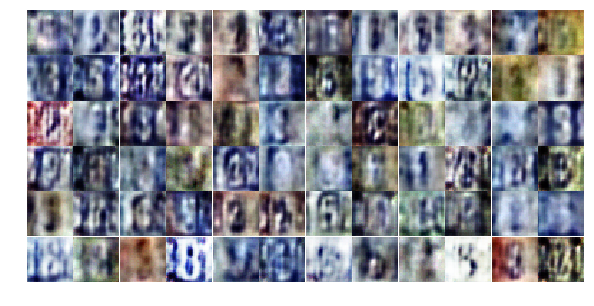

Epoch 10/20... Discriminator Loss: 0.4097... Generator Loss: 6.6773
Epoch 10/20... Discriminator Loss: 0.3903... Generator Loss: 1.6161
Epoch 10/20... Discriminator Loss: 0.2510... Generator Loss: 2.2451
Epoch 10/20... Discriminator Loss: 0.7686... Generator Loss: 0.8792
Epoch 11/20... Discriminator Loss: 1.1492... Generator Loss: 0.5537
Epoch 11/20... Discriminator Loss: 2.6800... Generator Loss: 2.4091
Epoch 11/20... Discriminator Loss: 0.5620... Generator Loss: 1.5289
Epoch 11/20... Discriminator Loss: 1.2609... Generator Loss: 0.4258
Epoch 11/20... Discriminator Loss: 0.3217... Generator Loss: 2.5535
Epoch 11/20... Discriminator Loss: 0.3759... Generator Loss: 1.6929


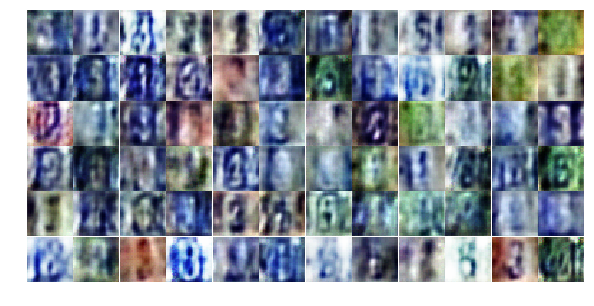

Epoch 11/20... Discriminator Loss: 0.1646... Generator Loss: 7.0044
Epoch 11/20... Discriminator Loss: 0.2360... Generator Loss: 2.4694
Epoch 11/20... Discriminator Loss: 0.4503... Generator Loss: 3.8504
Epoch 11/20... Discriminator Loss: 0.1142... Generator Loss: 4.5010
Epoch 11/20... Discriminator Loss: 0.5702... Generator Loss: 1.1435
Epoch 11/20... Discriminator Loss: 0.6799... Generator Loss: 1.0674
Epoch 11/20... Discriminator Loss: 0.2246... Generator Loss: 4.2814
Epoch 11/20... Discriminator Loss: 0.3544... Generator Loss: 1.8332
Epoch 12/20... Discriminator Loss: 0.1446... Generator Loss: 3.1011
Epoch 12/20... Discriminator Loss: 1.3158... Generator Loss: 0.4058


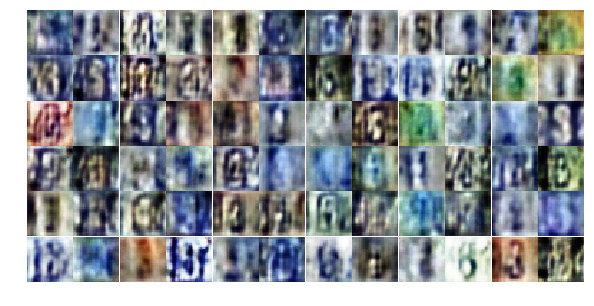

Epoch 12/20... Discriminator Loss: 1.4619... Generator Loss: 0.3814
Epoch 12/20... Discriminator Loss: 0.4001... Generator Loss: 4.7366
Epoch 12/20... Discriminator Loss: 1.0397... Generator Loss: 0.5926
Epoch 12/20... Discriminator Loss: 0.1586... Generator Loss: 4.1886
Epoch 12/20... Discriminator Loss: 0.7646... Generator Loss: 0.9276
Epoch 12/20... Discriminator Loss: 0.2824... Generator Loss: 3.5051
Epoch 12/20... Discriminator Loss: 0.9259... Generator Loss: 4.0626
Epoch 12/20... Discriminator Loss: 0.3290... Generator Loss: 3.3625
Epoch 12/20... Discriminator Loss: 0.4771... Generator Loss: 4.5632
Epoch 12/20... Discriminator Loss: 1.3469... Generator Loss: 4.2005


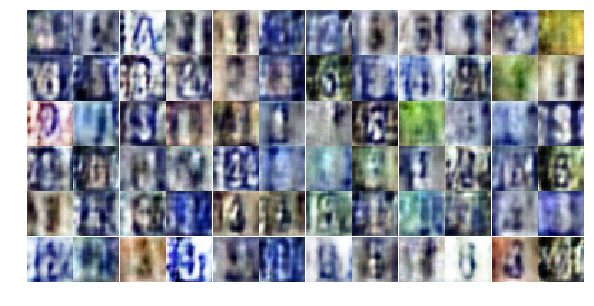

Epoch 12/20... Discriminator Loss: 0.2169... Generator Loss: 2.1828
Epoch 12/20... Discriminator Loss: 0.3874... Generator Loss: 5.1955
Epoch 13/20... Discriminator Loss: 0.2447... Generator Loss: 2.3211
Epoch 13/20... Discriminator Loss: 0.5371... Generator Loss: 3.7311
Epoch 13/20... Discriminator Loss: 0.1151... Generator Loss: 6.3688
Epoch 13/20... Discriminator Loss: 0.3115... Generator Loss: 2.6769
Epoch 13/20... Discriminator Loss: 0.1789... Generator Loss: 2.4544
Epoch 13/20... Discriminator Loss: 0.0835... Generator Loss: 4.6324
Epoch 13/20... Discriminator Loss: 0.0854... Generator Loss: 5.3045
Epoch 13/20... Discriminator Loss: 0.2273... Generator Loss: 2.9605


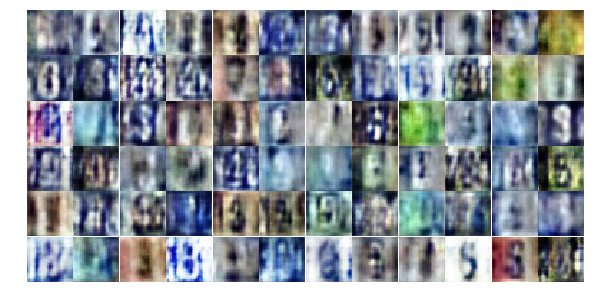

Epoch 13/20... Discriminator Loss: 0.4023... Generator Loss: 2.0284
Epoch 13/20... Discriminator Loss: 1.5367... Generator Loss: 0.3616
Epoch 13/20... Discriminator Loss: 3.7073... Generator Loss: 3.5202
Epoch 13/20... Discriminator Loss: 0.7612... Generator Loss: 0.8412
Epoch 13/20... Discriminator Loss: 0.4548... Generator Loss: 1.5915
Epoch 13/20... Discriminator Loss: 0.6889... Generator Loss: 1.0632
Epoch 13/20... Discriminator Loss: 0.4973... Generator Loss: 1.4411
Epoch 14/20... Discriminator Loss: 0.8457... Generator Loss: 0.9037
Epoch 14/20... Discriminator Loss: 0.4984... Generator Loss: 1.5876
Epoch 14/20... Discriminator Loss: 0.3018... Generator Loss: 4.9473


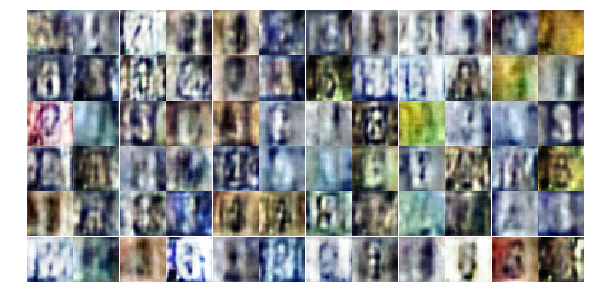

Epoch 14/20... Discriminator Loss: 0.5526... Generator Loss: 3.6570
Epoch 14/20... Discriminator Loss: 0.3530... Generator Loss: 5.0140
Epoch 14/20... Discriminator Loss: 0.5683... Generator Loss: 1.2417
Epoch 14/20... Discriminator Loss: 0.4980... Generator Loss: 1.3500
Epoch 14/20... Discriminator Loss: 1.1414... Generator Loss: 0.5199
Epoch 14/20... Discriminator Loss: 0.9967... Generator Loss: 0.6707
Epoch 14/20... Discriminator Loss: 0.8866... Generator Loss: 0.7325
Epoch 14/20... Discriminator Loss: 1.1408... Generator Loss: 0.5173
Epoch 14/20... Discriminator Loss: 0.1827... Generator Loss: 4.4636
Epoch 14/20... Discriminator Loss: 0.3395... Generator Loss: 5.7263


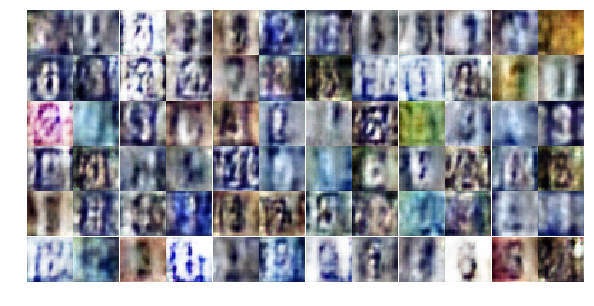

Epoch 14/20... Discriminator Loss: 0.1486... Generator Loss: 2.7697
Epoch 15/20... Discriminator Loss: 1.4546... Generator Loss: 0.3601
Epoch 15/20... Discriminator Loss: 0.1819... Generator Loss: 3.4066
Epoch 15/20... Discriminator Loss: 0.6200... Generator Loss: 5.1438
Epoch 15/20... Discriminator Loss: 1.0793... Generator Loss: 0.7461
Epoch 15/20... Discriminator Loss: 0.4680... Generator Loss: 2.1846
Epoch 15/20... Discriminator Loss: 1.2368... Generator Loss: 1.2967
Epoch 15/20... Discriminator Loss: 0.4427... Generator Loss: 5.6158
Epoch 15/20... Discriminator Loss: 1.4956... Generator Loss: 0.3461
Epoch 15/20... Discriminator Loss: 0.8340... Generator Loss: 3.9007


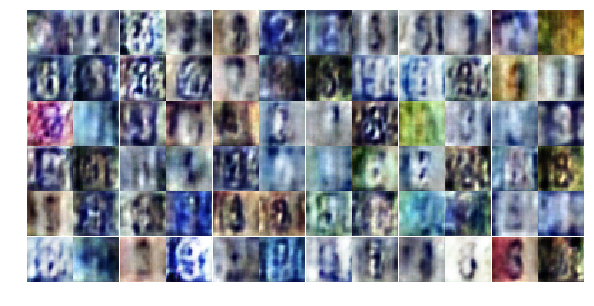

Epoch 15/20... Discriminator Loss: 0.3031... Generator Loss: 2.4189
Epoch 15/20... Discriminator Loss: 1.7982... Generator Loss: 0.2573
Epoch 15/20... Discriminator Loss: 0.3556... Generator Loss: 2.2507
Epoch 15/20... Discriminator Loss: 0.3403... Generator Loss: 1.8976
Epoch 15/20... Discriminator Loss: 0.1995... Generator Loss: 6.3254
Epoch 15/20... Discriminator Loss: 1.0888... Generator Loss: 0.5698
Epoch 16/20... Discriminator Loss: 0.3514... Generator Loss: 3.6220
Epoch 16/20... Discriminator Loss: 0.7284... Generator Loss: 0.9308
Epoch 16/20... Discriminator Loss: 0.2430... Generator Loss: 3.7681
Epoch 16/20... Discriminator Loss: 0.4321... Generator Loss: 2.7149


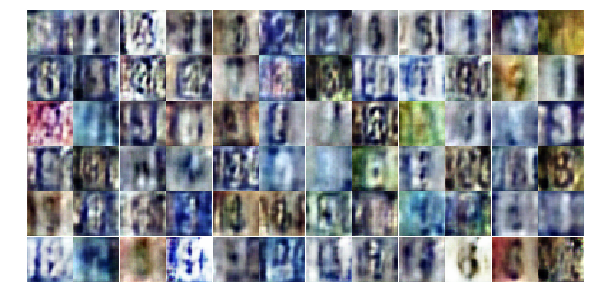

Epoch 16/20... Discriminator Loss: 0.8746... Generator Loss: 3.9177
Epoch 16/20... Discriminator Loss: 0.7432... Generator Loss: 0.9136
Epoch 16/20... Discriminator Loss: 1.3625... Generator Loss: 0.4176
Epoch 16/20... Discriminator Loss: 0.4427... Generator Loss: 1.5601
Epoch 16/20... Discriminator Loss: 0.4827... Generator Loss: 1.3990
Epoch 16/20... Discriminator Loss: 0.8285... Generator Loss: 0.9937
Epoch 16/20... Discriminator Loss: 0.1909... Generator Loss: 3.4396
Epoch 16/20... Discriminator Loss: 0.4676... Generator Loss: 1.6611
Epoch 16/20... Discriminator Loss: 0.3306... Generator Loss: 3.7322
Epoch 16/20... Discriminator Loss: 0.7259... Generator Loss: 4.0924


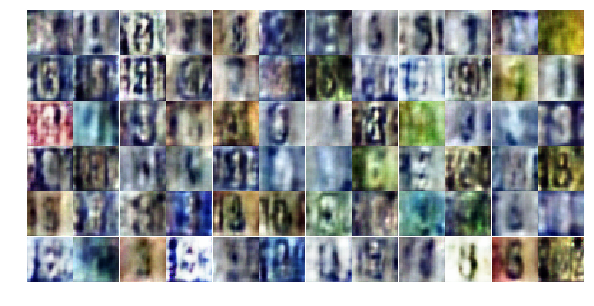

Epoch 17/20... Discriminator Loss: 0.2069... Generator Loss: 2.4339
Epoch 17/20... Discriminator Loss: 0.2298... Generator Loss: 2.9906
Epoch 17/20... Discriminator Loss: 0.4379... Generator Loss: 1.9155
Epoch 17/20... Discriminator Loss: 0.5344... Generator Loss: 1.5786
Epoch 17/20... Discriminator Loss: 0.6201... Generator Loss: 1.2835
Epoch 17/20... Discriminator Loss: 0.5391... Generator Loss: 1.4218
Epoch 17/20... Discriminator Loss: 0.8952... Generator Loss: 0.8129
Epoch 17/20... Discriminator Loss: 0.8644... Generator Loss: 0.8339
Epoch 17/20... Discriminator Loss: 1.2708... Generator Loss: 0.4971
Epoch 17/20... Discriminator Loss: 0.4166... Generator Loss: 4.4930


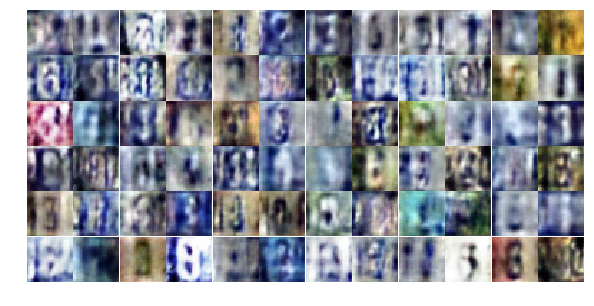

Epoch 17/20... Discriminator Loss: 0.4353... Generator Loss: 1.5410
Epoch 17/20... Discriminator Loss: 0.3072... Generator Loss: 3.6635
Epoch 17/20... Discriminator Loss: 0.4128... Generator Loss: 4.3102
Epoch 17/20... Discriminator Loss: 1.7363... Generator Loss: 0.3961
Epoch 18/20... Discriminator Loss: 0.6482... Generator Loss: 1.4521
Epoch 18/20... Discriminator Loss: 0.6099... Generator Loss: 1.0578
Epoch 18/20... Discriminator Loss: 0.5163... Generator Loss: 1.6109
Epoch 18/20... Discriminator Loss: 0.3275... Generator Loss: 2.3778
Epoch 18/20... Discriminator Loss: 0.3566... Generator Loss: 1.7828
Epoch 18/20... Discriminator Loss: 0.3074... Generator Loss: 2.6811


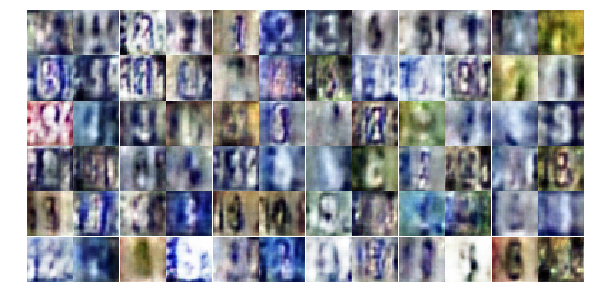

Epoch 18/20... Discriminator Loss: 0.5270... Generator Loss: 1.3643
Epoch 18/20... Discriminator Loss: 0.2938... Generator Loss: 2.2181
Epoch 18/20... Discriminator Loss: 0.6825... Generator Loss: 1.0666
Epoch 18/20... Discriminator Loss: 0.3073... Generator Loss: 2.6131
Epoch 18/20... Discriminator Loss: 0.2644... Generator Loss: 3.3273
Epoch 18/20... Discriminator Loss: 0.3353... Generator Loss: 1.8597
Epoch 18/20... Discriminator Loss: 0.3069... Generator Loss: 2.3155
Epoch 18/20... Discriminator Loss: 0.1855... Generator Loss: 4.5964
Epoch 18/20... Discriminator Loss: 0.5751... Generator Loss: 1.2283
Epoch 19/20... Discriminator Loss: 0.1647... Generator Loss: 3.0426


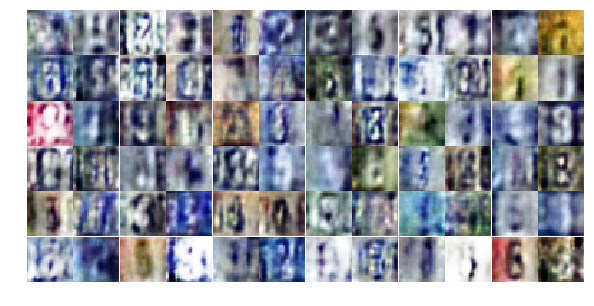

Epoch 19/20... Discriminator Loss: 0.4284... Generator Loss: 5.0651
Epoch 19/20... Discriminator Loss: 0.3333... Generator Loss: 1.9424
Epoch 19/20... Discriminator Loss: 0.5516... Generator Loss: 1.2410
Epoch 19/20... Discriminator Loss: 2.4073... Generator Loss: 0.1829
Epoch 19/20... Discriminator Loss: 0.6830... Generator Loss: 1.6889
Epoch 19/20... Discriminator Loss: 0.6820... Generator Loss: 1.0742
Epoch 19/20... Discriminator Loss: 0.2675... Generator Loss: 3.9465
Epoch 19/20... Discriminator Loss: 0.2690... Generator Loss: 3.8167
Epoch 19/20... Discriminator Loss: 0.4157... Generator Loss: 2.0256
Epoch 19/20... Discriminator Loss: 0.1968... Generator Loss: 2.5060


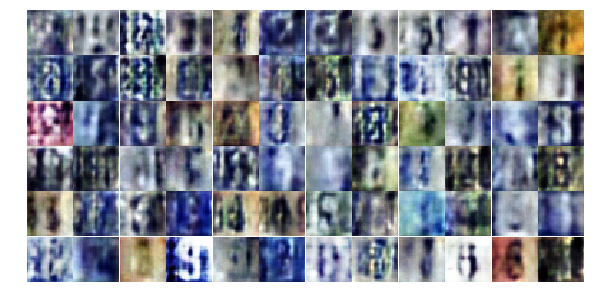

Epoch 19/20... Discriminator Loss: 0.2465... Generator Loss: 2.3290
Epoch 19/20... Discriminator Loss: 0.4476... Generator Loss: 4.5118
Epoch 19/20... Discriminator Loss: 0.1693... Generator Loss: 3.7537
Epoch 20/20... Discriminator Loss: 0.8760... Generator Loss: 3.1826
Epoch 20/20... Discriminator Loss: 0.5189... Generator Loss: 1.7884
Epoch 20/20... Discriminator Loss: 0.2910... Generator Loss: 2.7241
Epoch 20/20... Discriminator Loss: 0.5379... Generator Loss: 1.2244
Epoch 20/20... Discriminator Loss: 1.2499... Generator Loss: 1.0982
Epoch 20/20... Discriminator Loss: 0.2966... Generator Loss: 2.4523
Epoch 20/20... Discriminator Loss: 0.2906... Generator Loss: 2.6040


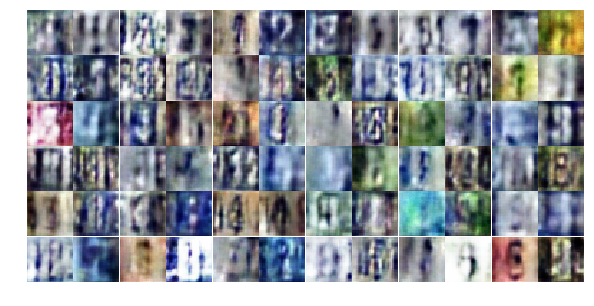

Epoch 20/20... Discriminator Loss: 0.2494... Generator Loss: 2.8601
Epoch 20/20... Discriminator Loss: 0.2516... Generator Loss: 2.6313
Epoch 20/20... Discriminator Loss: 0.6023... Generator Loss: 2.4047
Epoch 20/20... Discriminator Loss: 0.5114... Generator Loss: 1.3309
Epoch 20/20... Discriminator Loss: 0.3677... Generator Loss: 1.6710
Epoch 20/20... Discriminator Loss: 0.3058... Generator Loss: 2.3860
Epoch 20/20... Discriminator Loss: 0.8344... Generator Loss: 2.8228
Epoch 20/20... Discriminator Loss: 1.0453... Generator Loss: 0.7184


In [18]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

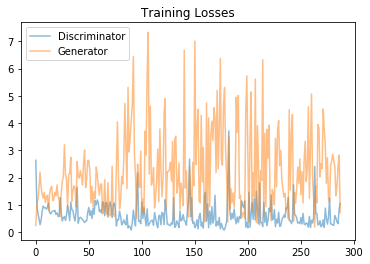

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

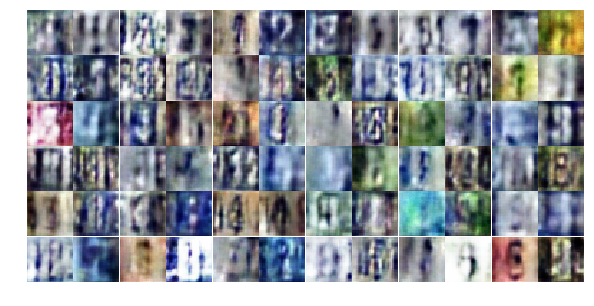

In [20]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))